<a href="https://colab.research.google.com/github/issei4683/issei4683-SMBC-Group-GREEN-DATA-Challenge-2024/blob/main/SMBC_Group_GREEN%C3%97DATA_Challenge_2024_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 必要なライブラリのインストール
!pip install pygeohash
!pip install catboost

# 警告を無効化（不要なメッセージを抑制）
import warnings
warnings.filterwarnings("ignore")

# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 進捗表示や効率化
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import gc  # メモリ管理

# モデリングライブラリ
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# 補助ライブラリ（モデル評価、データ前処理）
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

# 特殊ライブラリ
import pygeohash as pgh  # 緯度経度データのエンコード
import joblib  # モデル保存・読み込み
import math  # 数学関数

# システム処理
import os


  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6153 sha256=6de33da4f2398376f4cb859072d656441b7c701509564338de6b0f4322efd619
  Stored in directory: /root/.cache/pip/wheels/95/22/7a/35719e5f20cdc599cc837c67031a3ec2f011e1d418f57a37ce
Successfully built pygeohash
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00


In [5]:
# データの読み込み
train_df = pd.read_csv('/content/drive/MyDrive/data/train (1).csv')
test_df = pd.read_csv('/content/drive/MyDrive/data/test (1).csv')
del train_df['Unnamed: 0'], test_df['Unnamed: 0']
del train_df['FacilityName'], test_df['FacilityName']
del train_df['LocationAddress'], test_df['LocationAddress']
del train_df['ZIP'], test_df['ZIP']
del train_df['IndustryType'], test_df['IndustryType']
del train_df['SecondPrimaryNAICS'], test_df['SecondPrimaryNAICS']

# 📊データの視覚化





In [6]:
# データセットの形状と最初の行を確認
train_df.head()

,Latitude,Longitude,City,State,County,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
0,40.141389,-87.581111,DANVILLE,IL,VERMILION,17183.0,326121,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,37907.936721,45598.125851,52973.139946
1,38.475305,-81.278957,CLENDENIN,WV,KANAWHA,54039.0,486210,NaN,NaN,NaN,NaN,55507.543666,72387.334115,58225.196089,76376.547318,55910.066617
2,39.299820,-80.857170,GREENWOOD,WV,RITCHIE,54085.0,211112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55679.543214
3,35.490363,-119.042957,BAKERSFIELD,CA,KERN,6029.0,221112,NaN,NaN,NaN,NaN,54811.222708,69339.923002,63647.340038,53799.011225,61411.902782
4,41.532802,-81.636448,CLEVELAND,OH,CUYAHOGA,39035.0,221112,29553.796627,28337.832145,30840.825454,25153.901905,81812.306362,53823.561587,77391.157768,17662.966241,43100.469774


In [7]:
# カラム名、入力済行数、タイプの確認
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4655 entries, 0 to 4654
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Latitude                                4553 non-null   float64
 1   Longitude                               4553 non-null   float64
 2   City                                    4655 non-null   object 
 3   State                                   4655 non-null   object 
 4   County                                  4585 non-null   object 
 5   FIPScode                                4582 non-null   float64
 6   PrimaryNAICS                            4655 non-null   int64  
 7   TRI_Air_Emissions_10_in_lbs             1635 non-null   float64
 8   TRI_Air_Emissions_11_in_lbs             1635 non-null   float64
 9   TRI_Air_Emissions_12_in_lbs             1635 non-null   float64
 10  TRI_Air_Emissions_13_in_lbs             1635 non-null   floa

In [8]:
# 数値列の基本統計を確認
train_df.describe().round(2)

,Latitude,Longitude,FIPScode,PrimaryNAICS,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons
count,4553.00,4553.00,4582.00,4655.00,1635.00,1635.00,1635.00,1635.00,3953.00,4284.00,4395.00,4507.00,4655.00
mean,37.50,-93.13,29594.31,354701.00,61790.64,43853.46,53770.29,56007.09,248515.83,161206.84,315990.49,183400.57,252513.31
std,5.74,15.68,16565.38,145549.95,134498.34,55988.95,93977.13,109863.24,522511.03,264183.08,739584.33,402623.71,485466.93
min,13.39,-166.55,1001.00,111419.00,2279.51,34.45,2076.65,4656.52,108.94,0.82,201.00,26.89,559.81
25%,33.47,-98.50,17105.50,221112.00,25252.15,25319.05,22764.67,22905.88,51239.75,37339.35,48224.87,35477.81,41748.69
50%,37.87,-90.45,29034.00,325180.00,32041.87,31765.72,29667.09,29305.09,74403.47,61197.49,72426.84,57446.58,67897.93
75%,41.15,-82.60,45050.00,486210.00,40191.23,38329.10,36984.43,36755.02,167640.86,141860.78,227966.79,119554.36,210916.78
max,70.49,144.81,78010.00,928110.00,1251231.48,478366.46,743548.79,989230.80,3900222.23,2698567.31,6837259.91,4330235.71,4614102.60


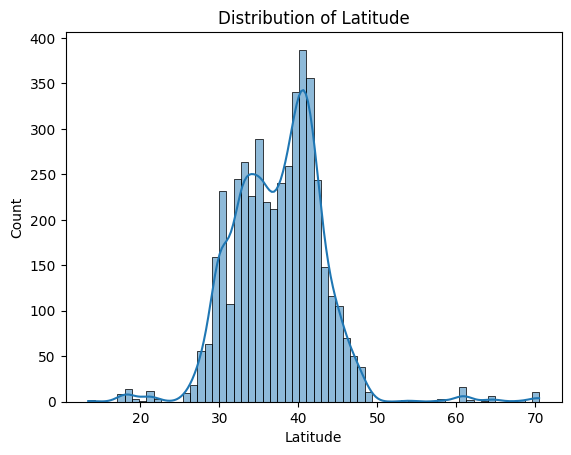

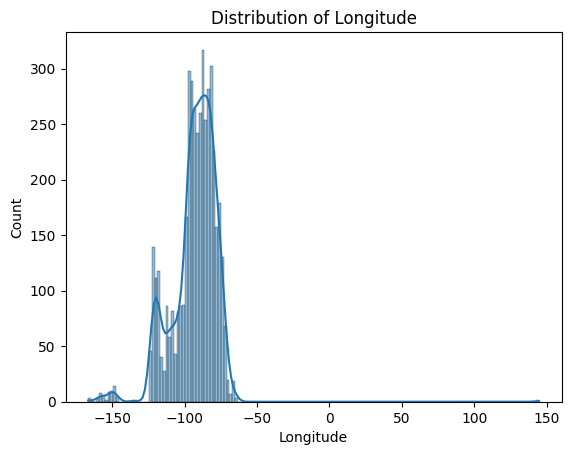

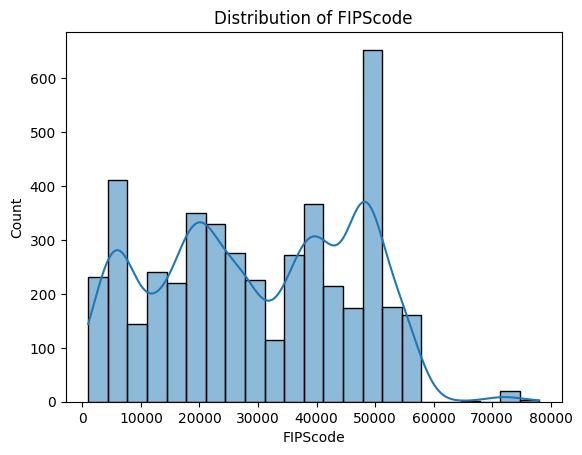

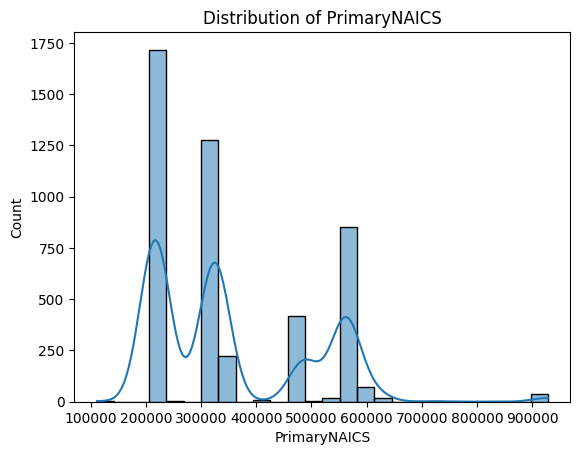

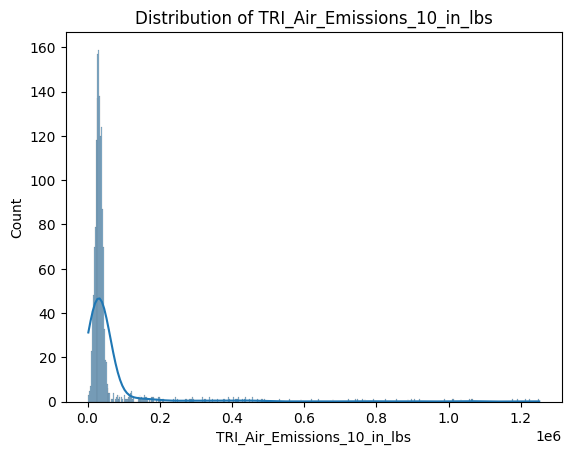

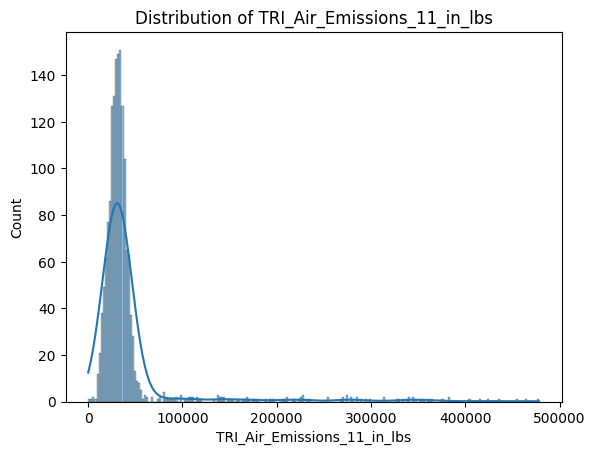

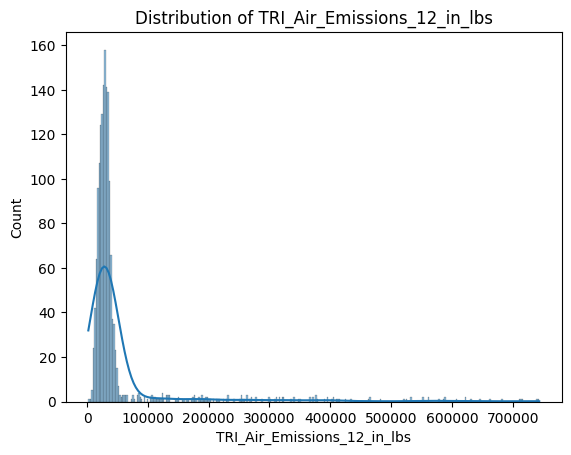

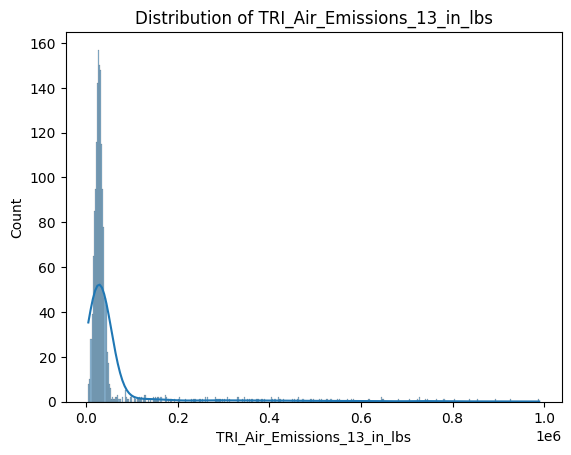

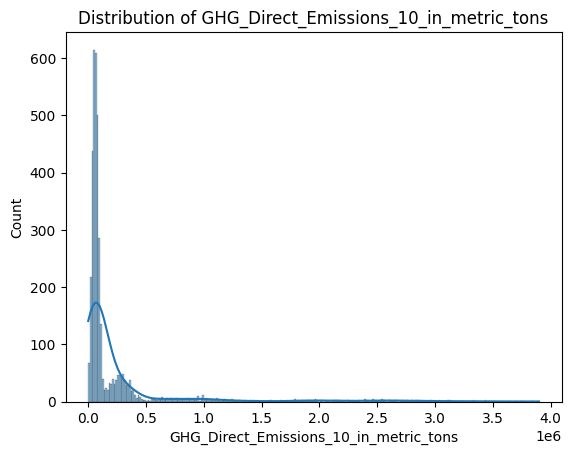

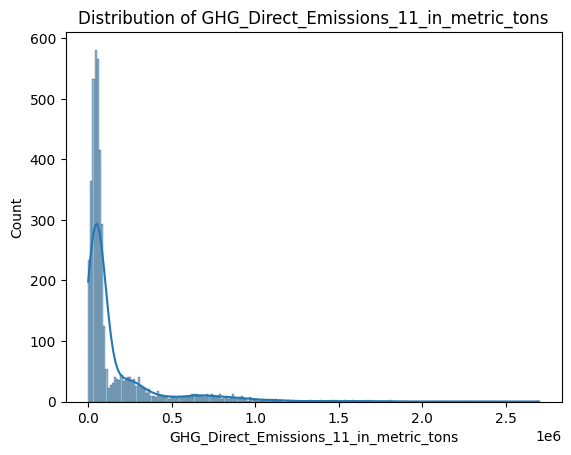

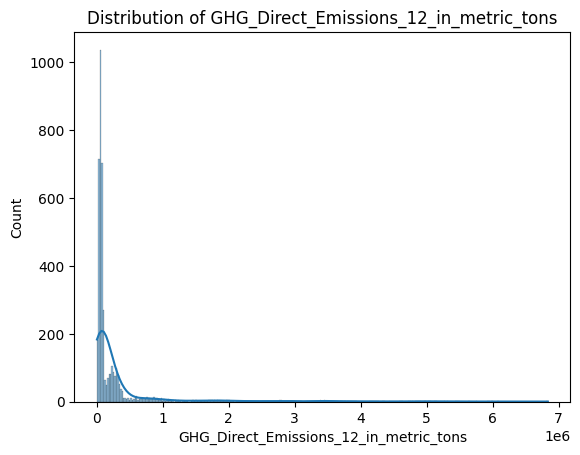

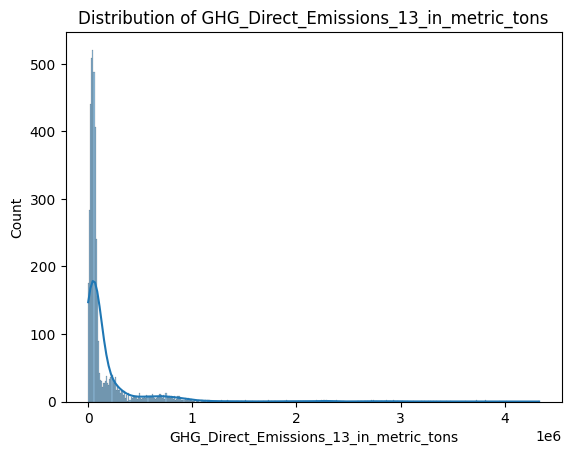

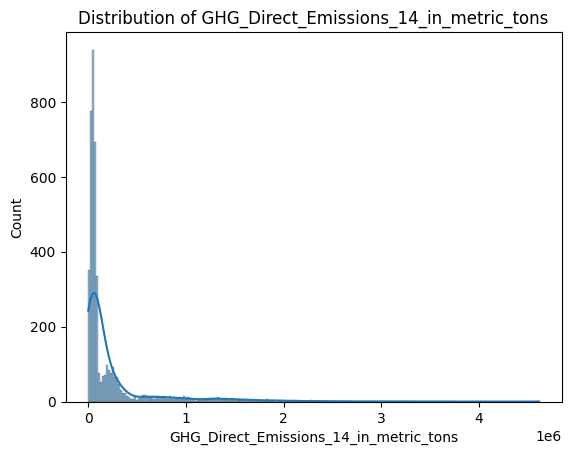

In [12]:
# カラムごとに個別の分布を表示
for col in train_df.select_dtypes(include=['float64', 'int64']).columns:
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

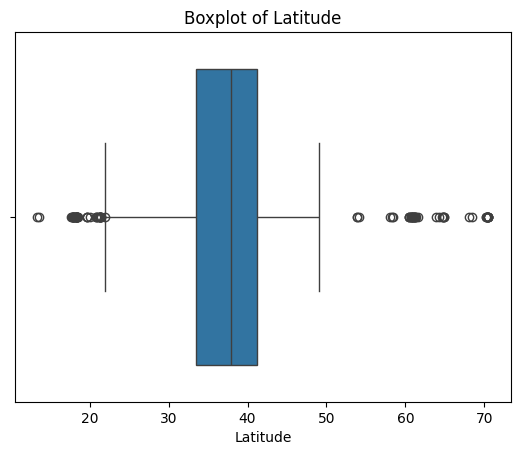

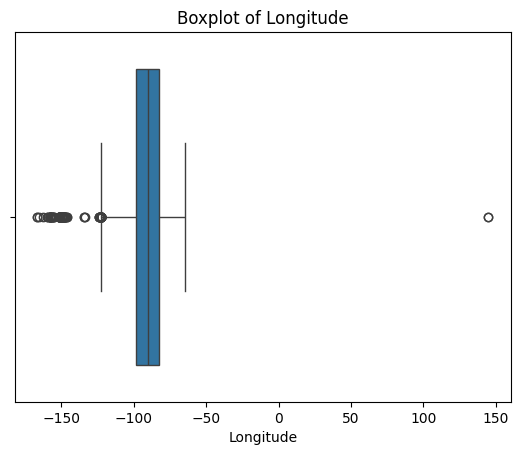

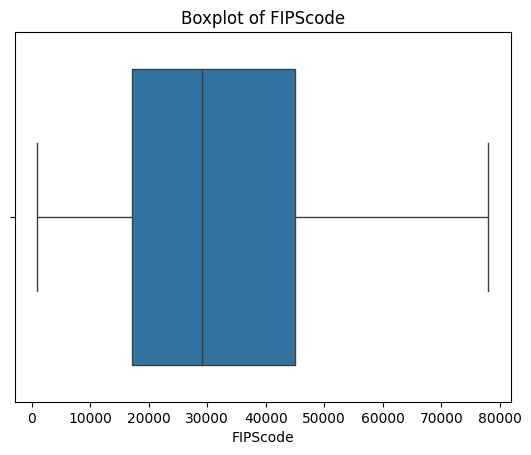

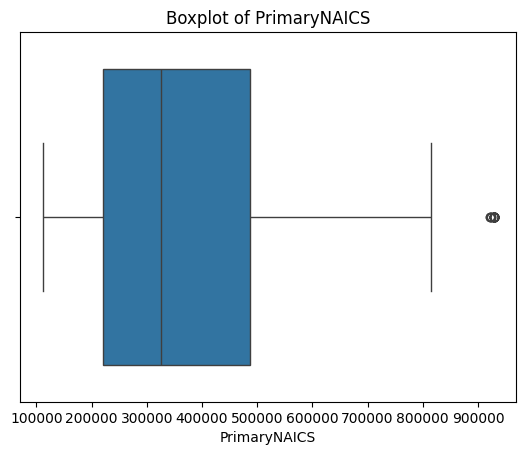

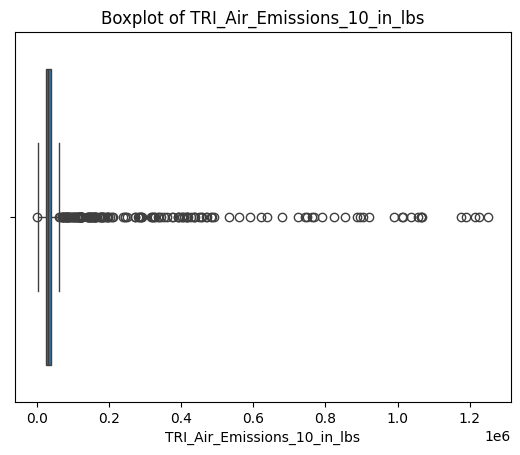

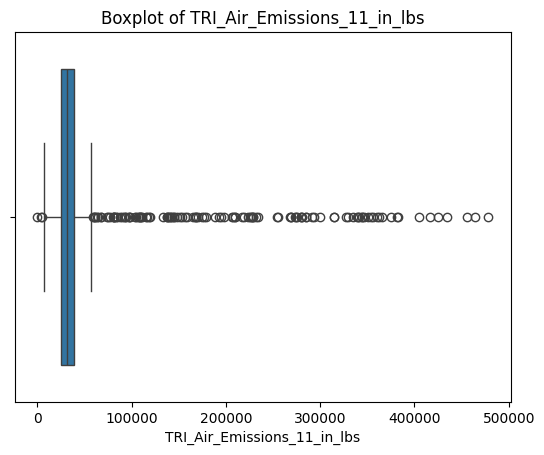

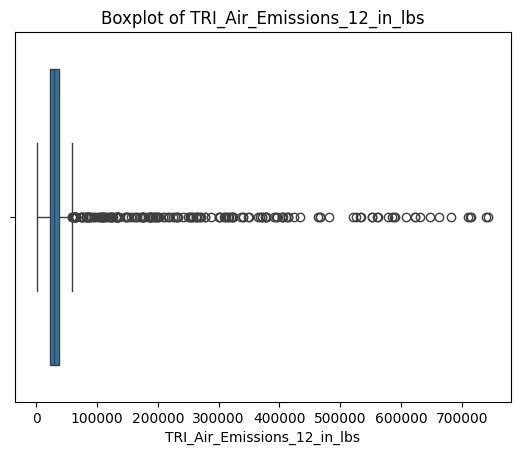

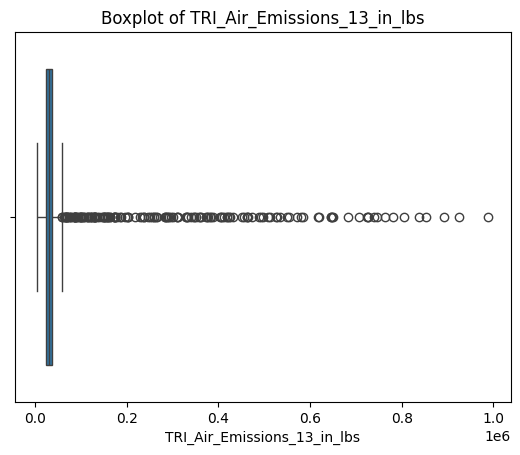

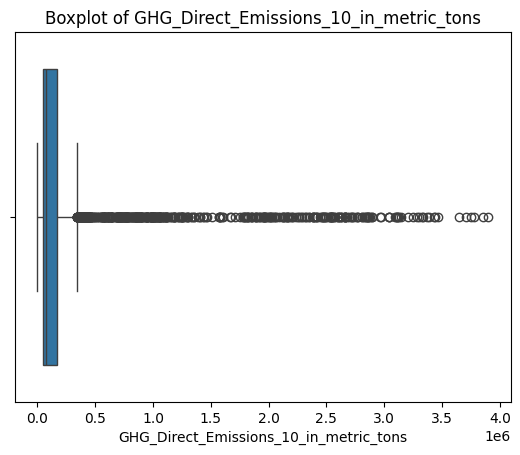

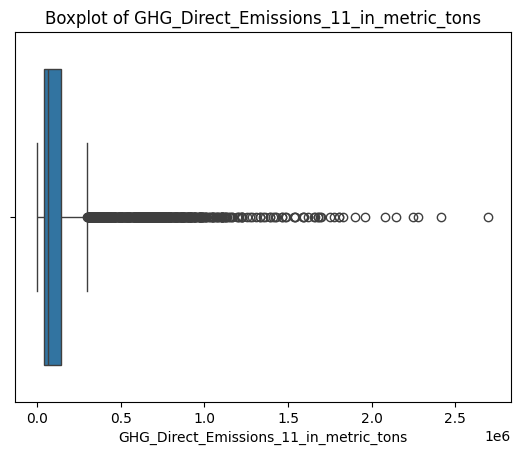

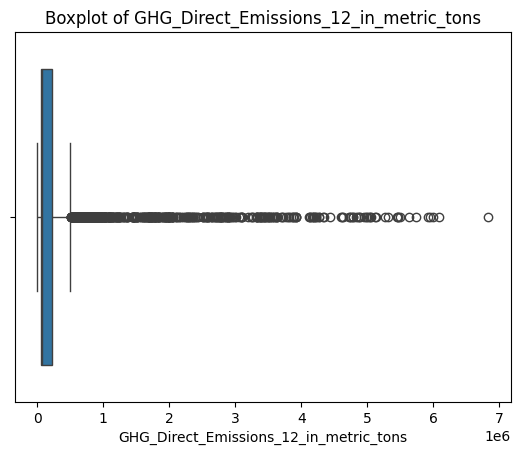

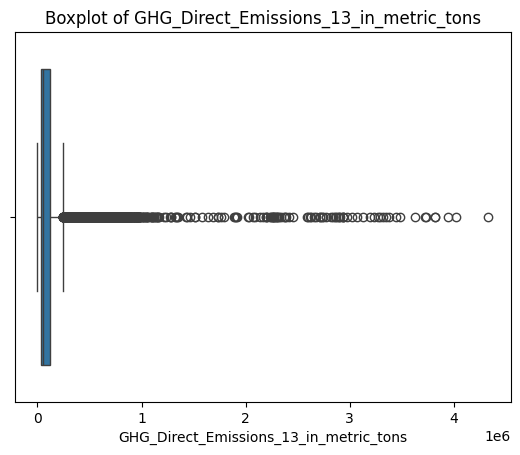

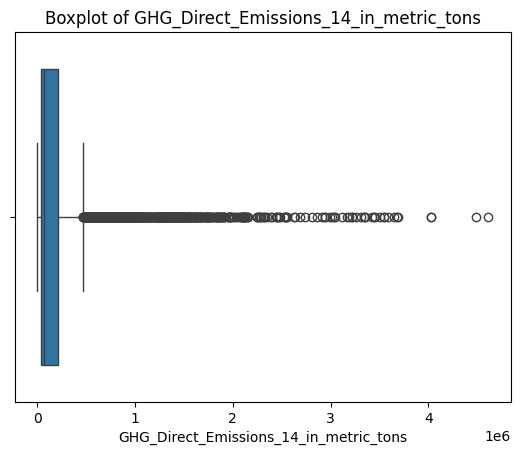

In [15]:
# 箱ひげ図で異常値を可視化
for col in train_df.select_dtypes(include=['float64', 'int64']).columns:
    sns.boxplot(x=train_df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

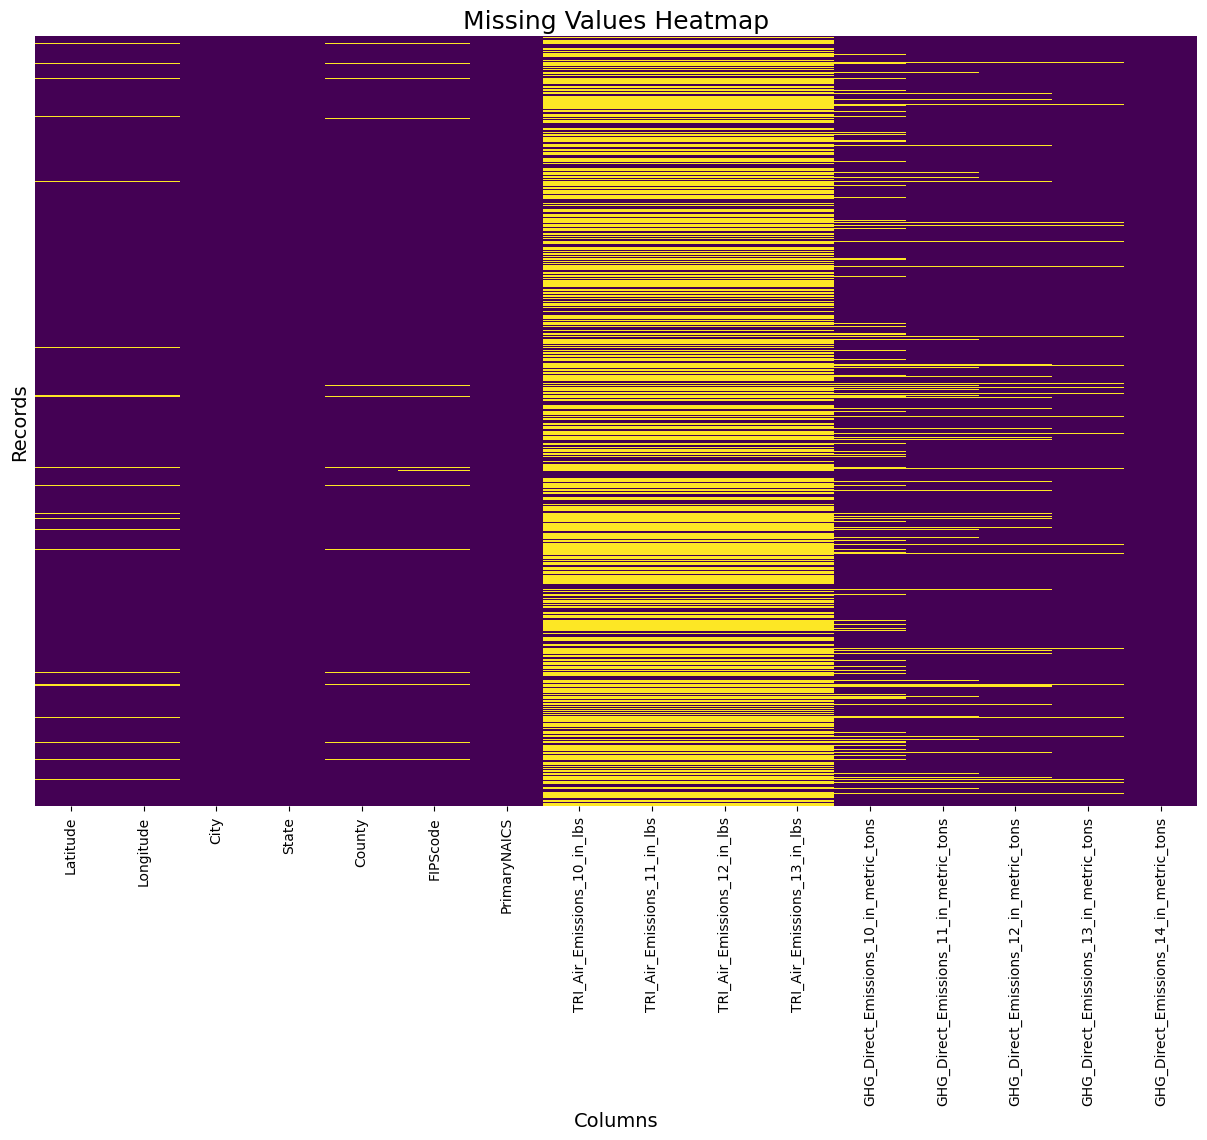

In [16]:
# グラフサイズの設定
plt.figure(figsize=(15, 10))

# 欠損値の位置をヒートマップで可視化
sns.heatmap(train_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)

# グラフタイトルとラベル
plt.title('Missing Values Heatmap', fontsize=18)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Records', fontsize=14)

# 表示
plt.show()


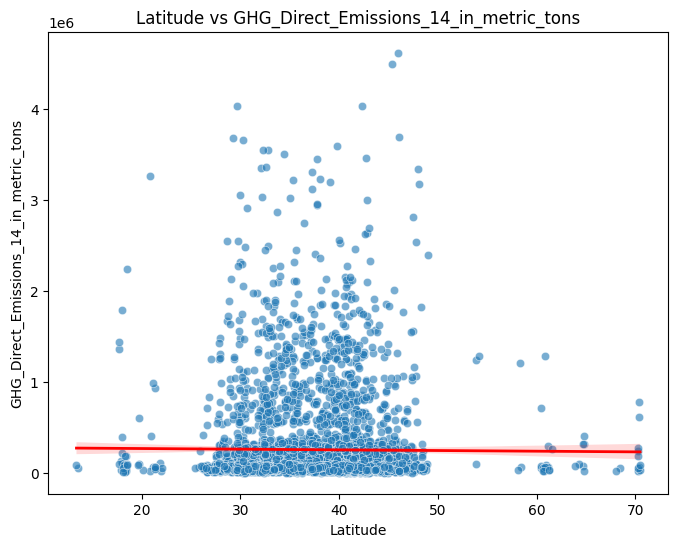

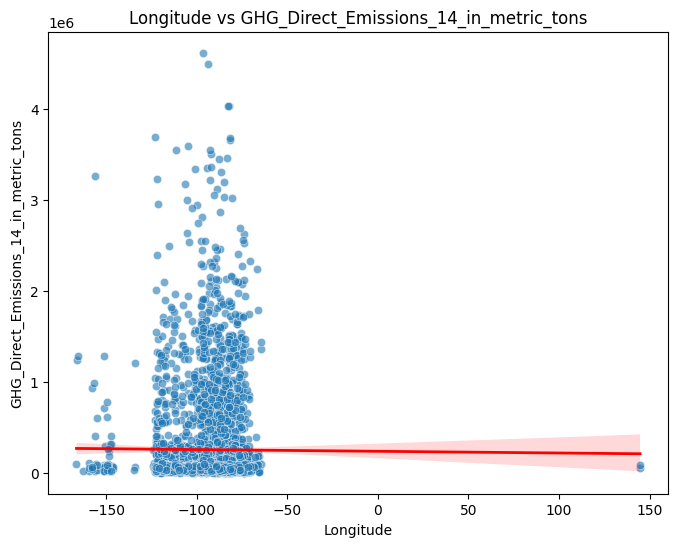

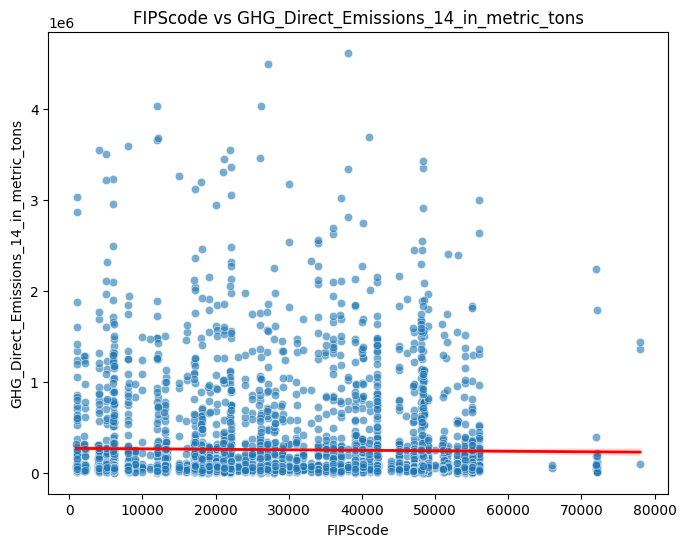

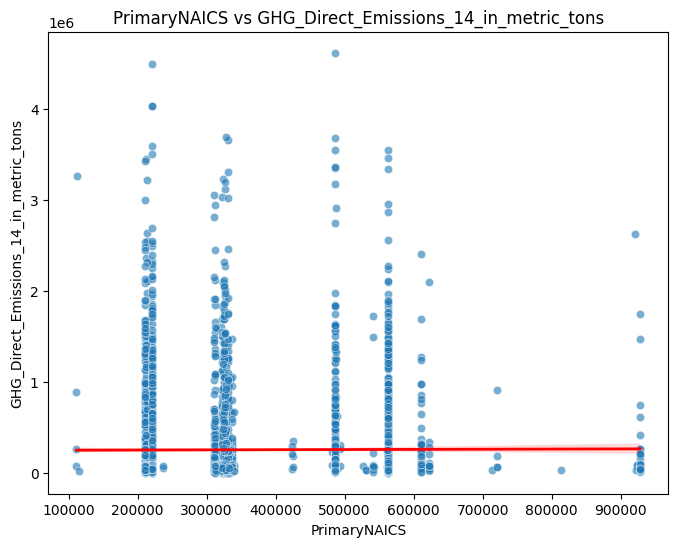

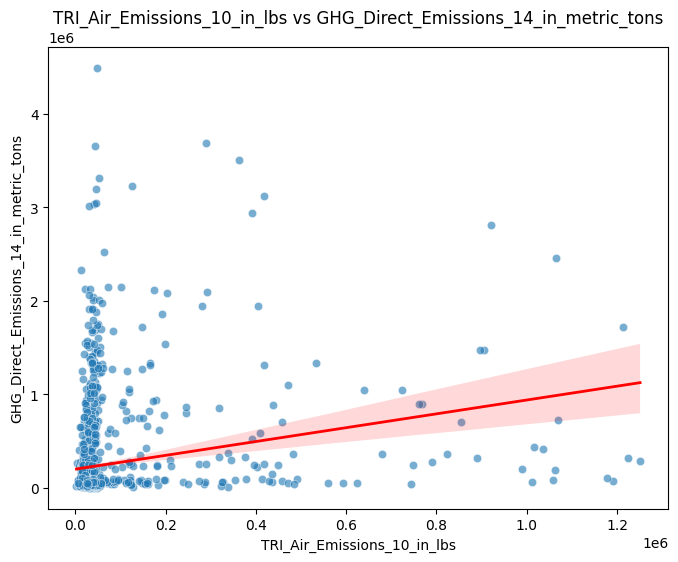

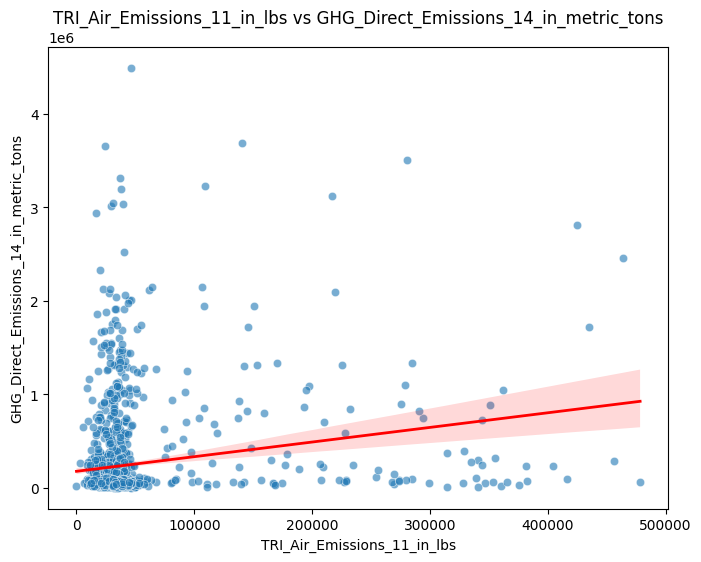

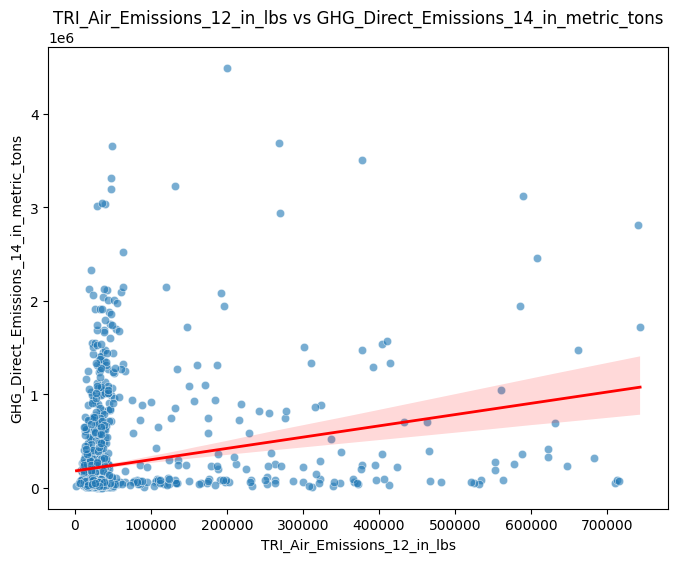

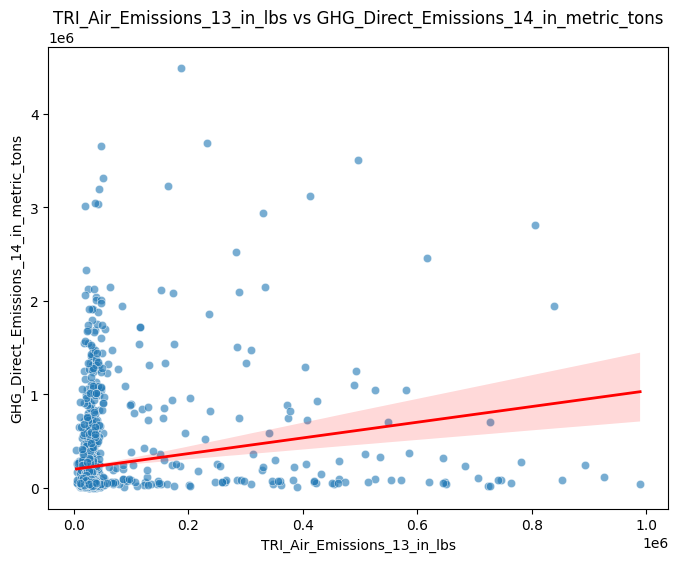

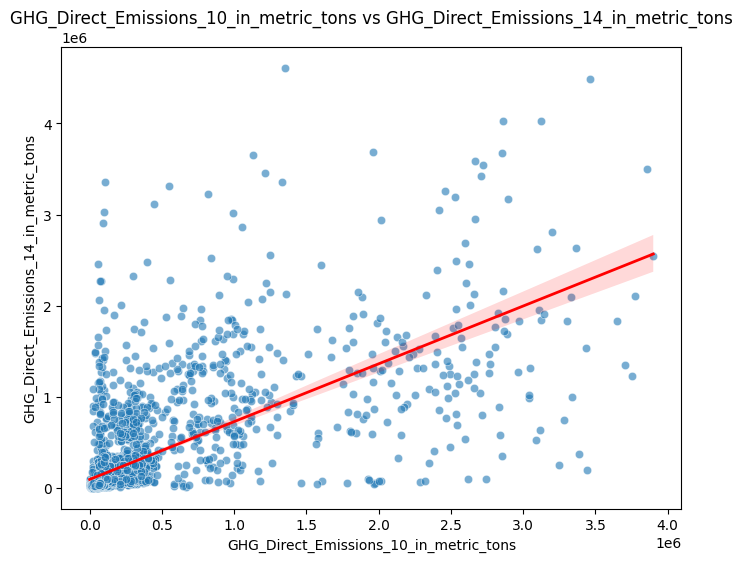

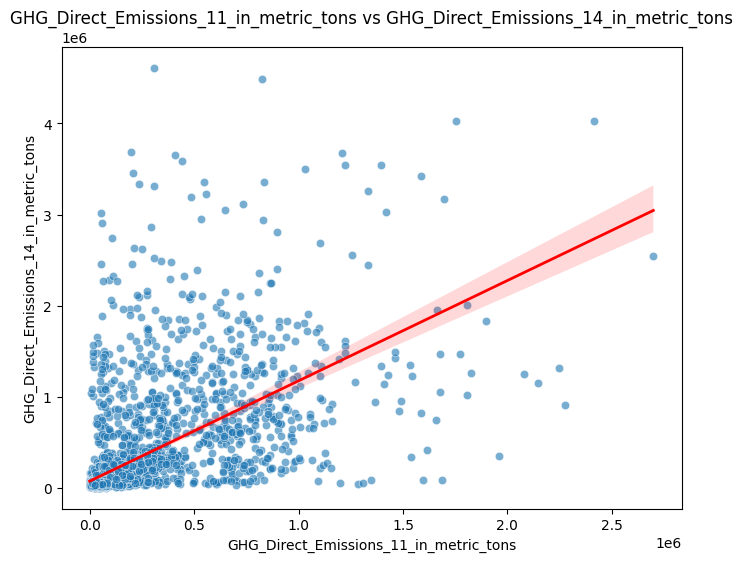

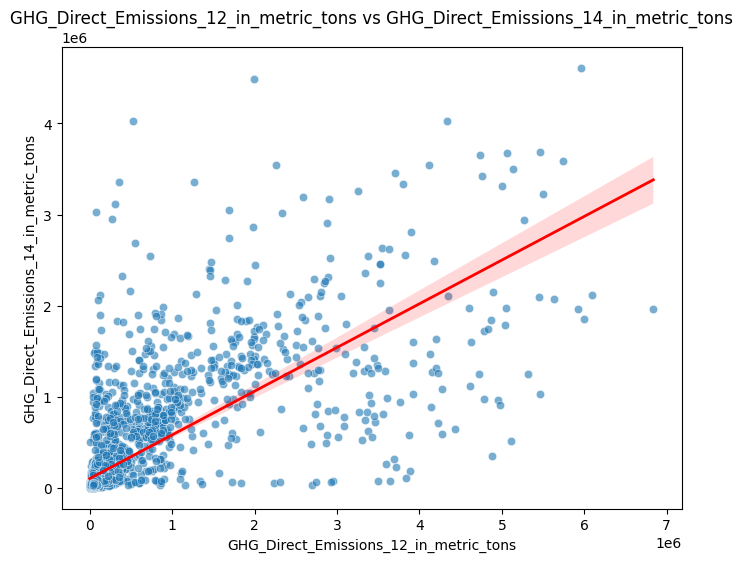

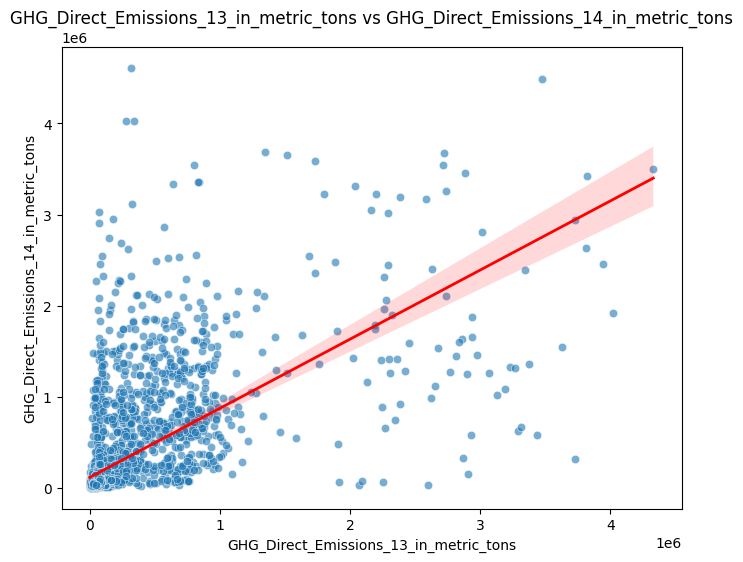

In [23]:
# ターゲット列と数値列の関係性
target_column = 'GHG_Direct_Emissions_14_in_metric_tons'  # ターゲット列名を指定

for col in train_df.select_dtypes(include=['float64', 'int64']).columns:
    if col != target_column:  # ターゲット列そのものを x 軸にするのを防ぐ
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=train_df[col], y=train_df[target_column], alpha=0.6)
        sns.regplot(x=train_df[col], y=train_df[target_column], scatter=False, color='red', line_kws={"linewidth": 2})  # 赤線を追加
        plt.title(f'{col} vs {target_column}')
        plt.xlabel(col)
        plt.ylabel(target_column)
        plt.show()

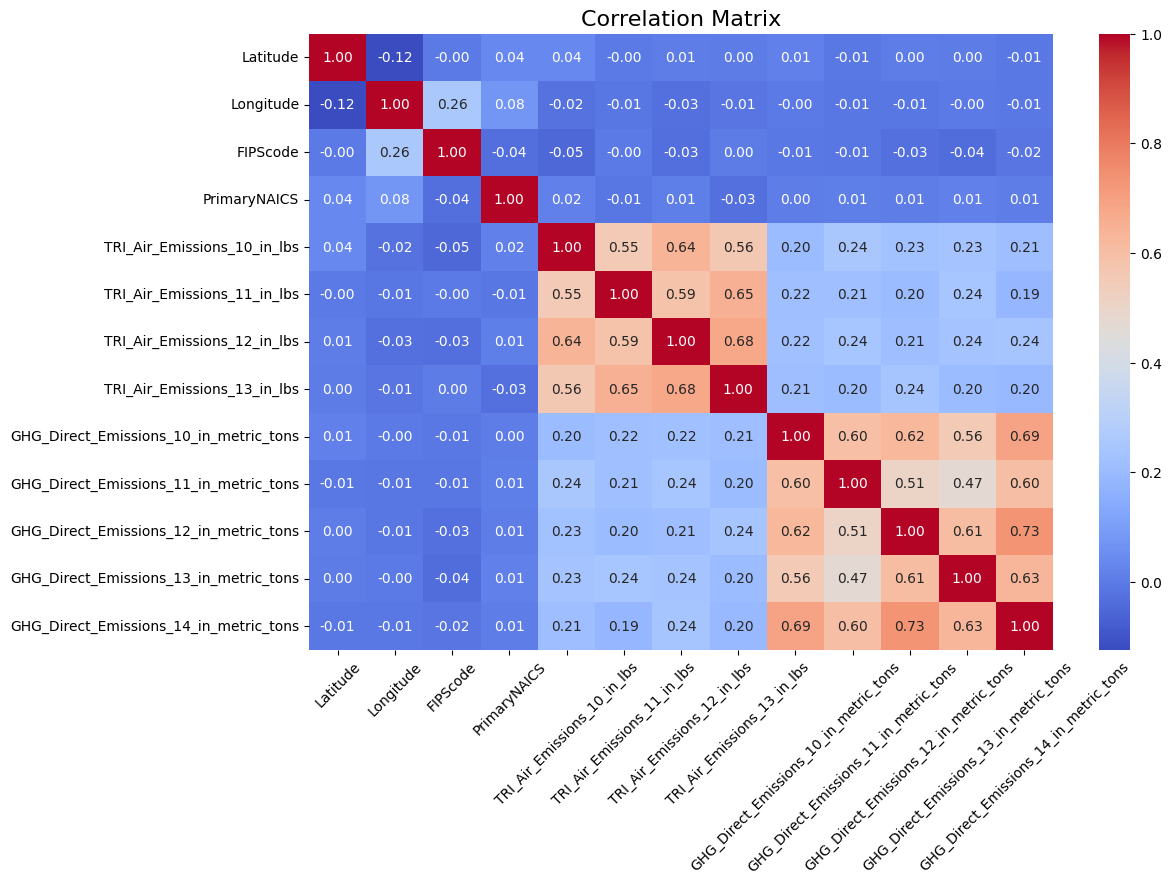

In [21]:
# 数値列に限定したデータフレームを取得
numeric_data = train_df.select_dtypes(include=['float64', 'int64'])

# 相関行列を計算
correlation_matrix = numeric_data.corr()

# 相関行列の可視化
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


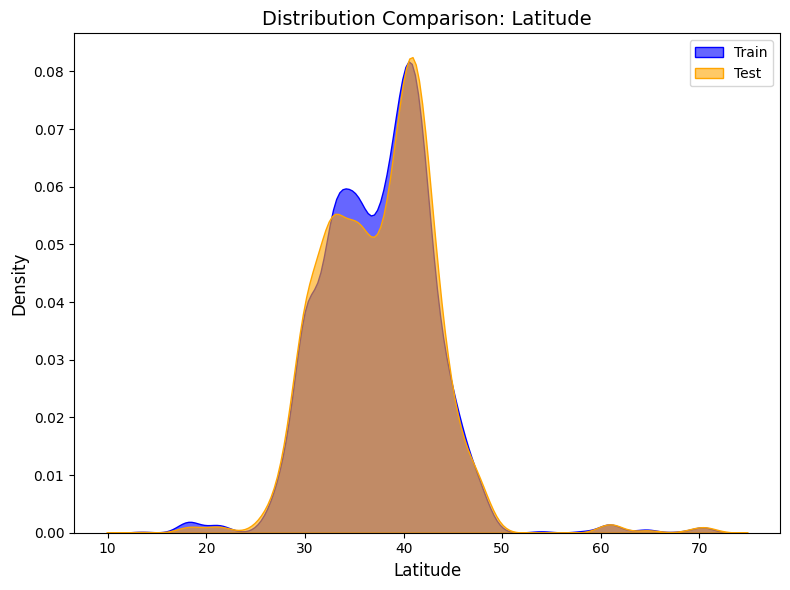

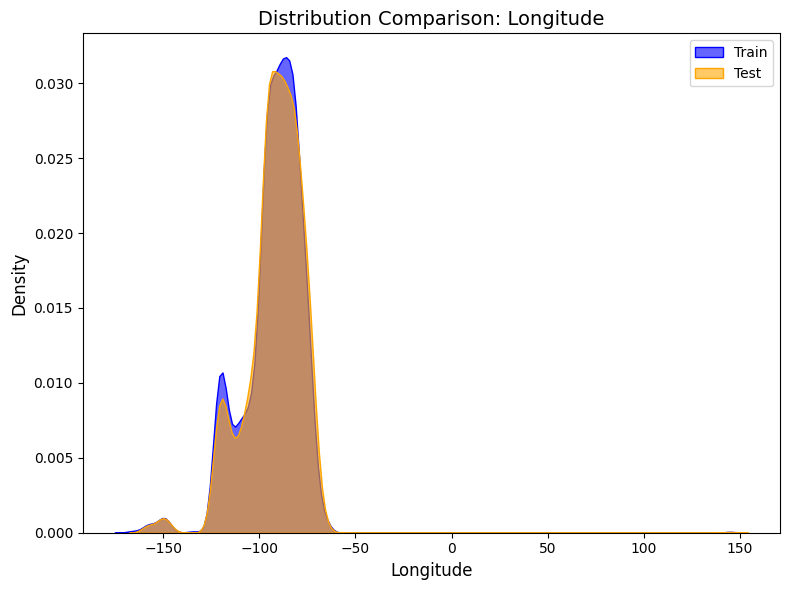

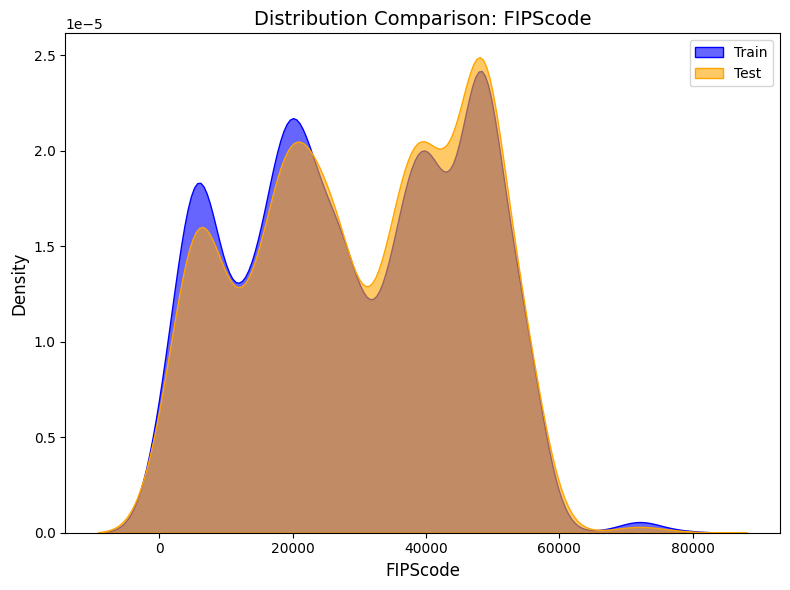

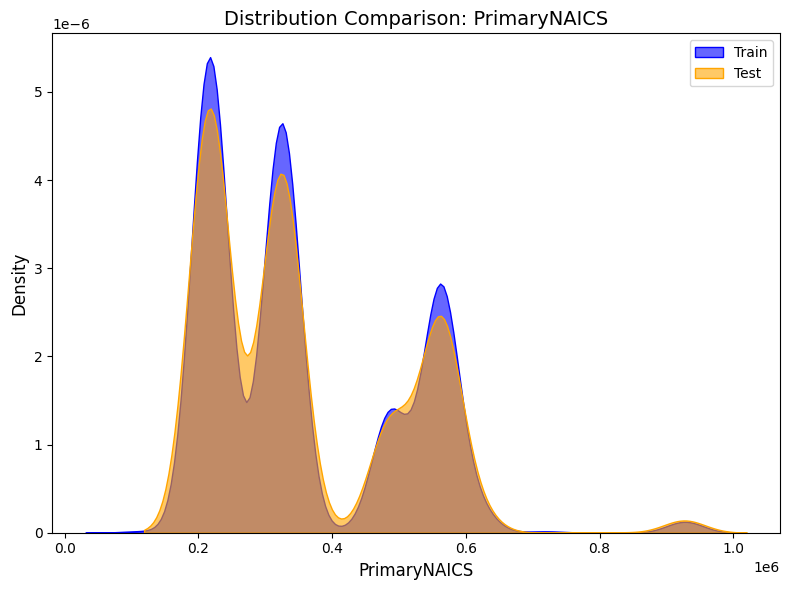

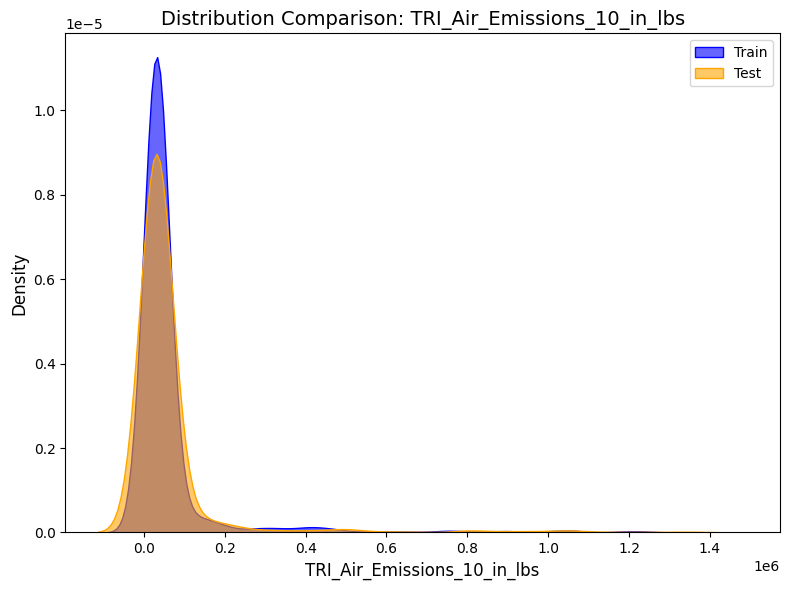

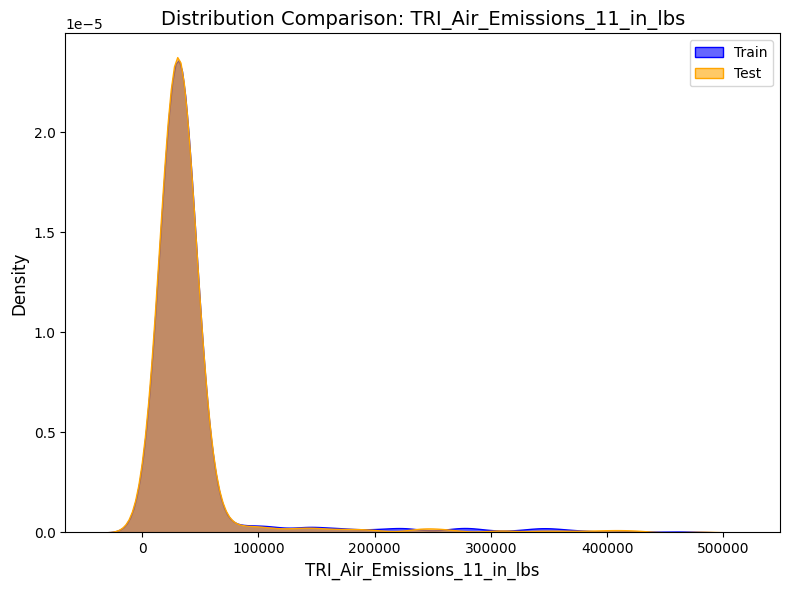

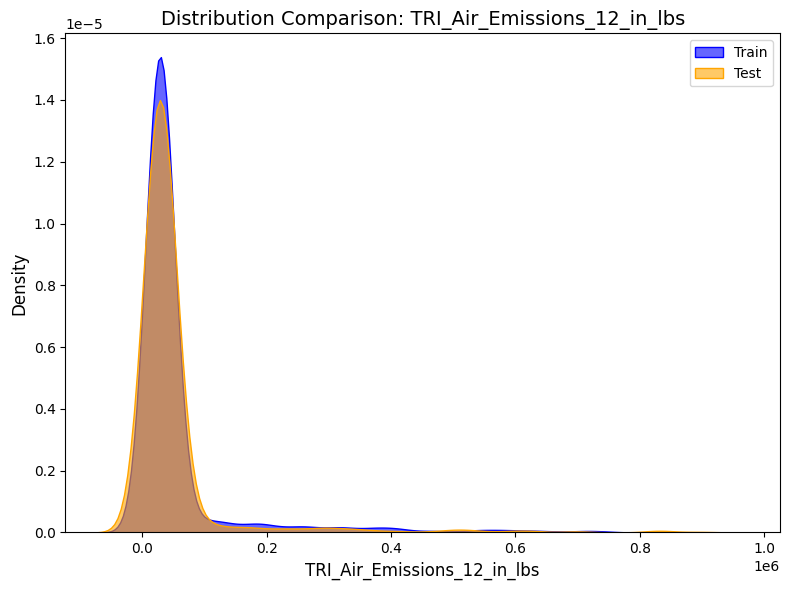

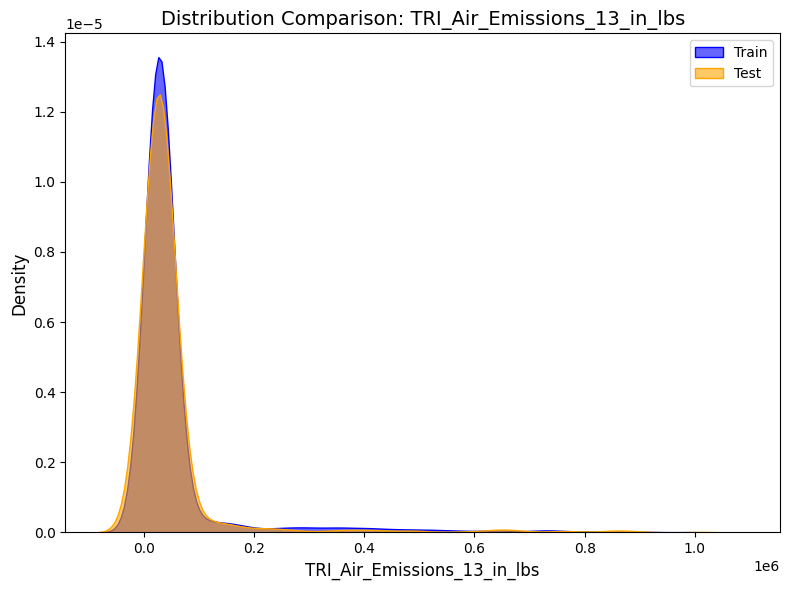

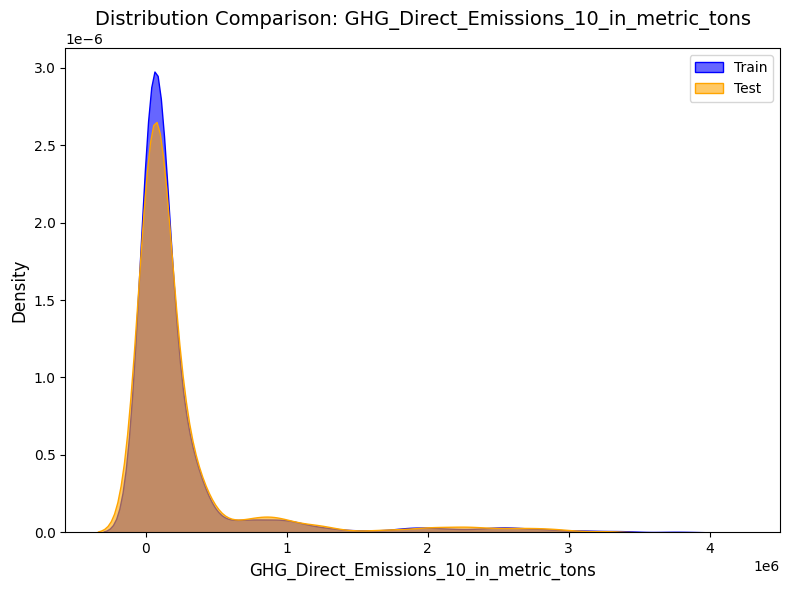

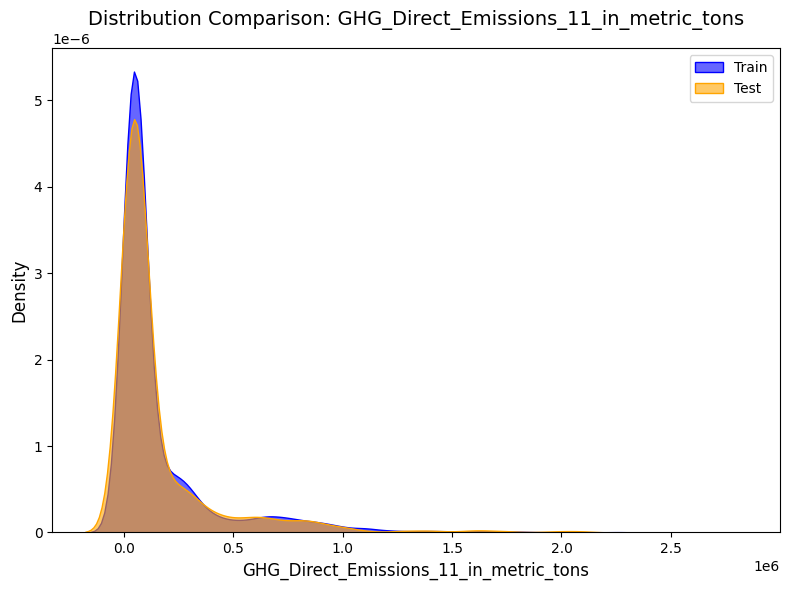

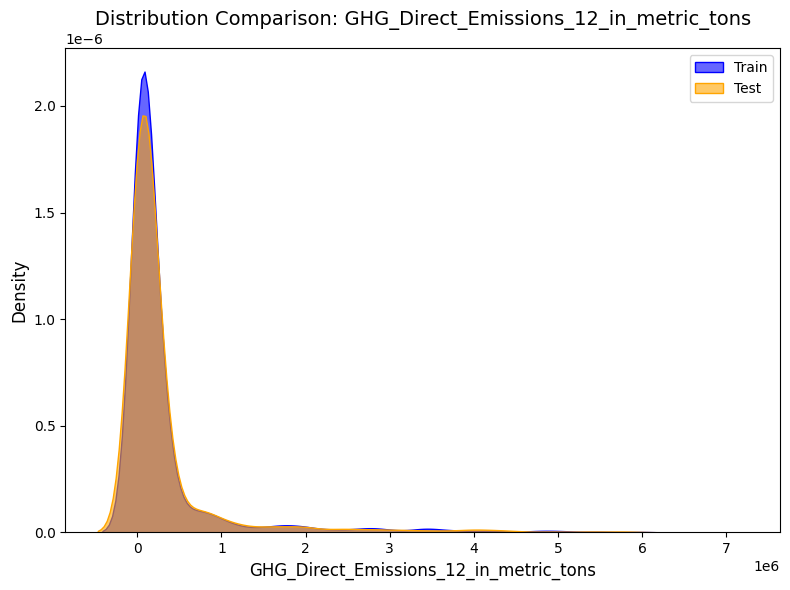

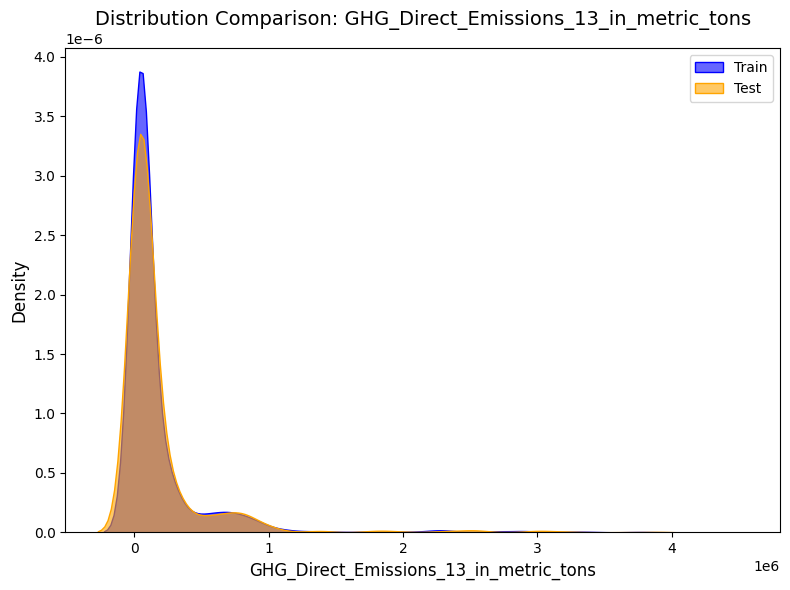

Column GHG_Direct_Emissions_14_in_metric_tons is not in test_df


In [25]:
# トレーニングデータとテストデータの分布を比較

numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    if col in test_df.columns:  # test_df に存在する列のみ処理
        plt.figure(figsize=(8, 6))
        sns.kdeplot(train_df[col], label='Train', shade=True, color="blue", alpha=0.6)
        sns.kdeplot(test_df[col], label='Test', shade=True, color="orange", alpha=0.6)
        plt.title(f'Distribution Comparison: {col}', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column {col} is not in test_df")


# 🛠️ 特徴量エンジニアリング

In [26]:
# Primary NAICSの前処理をするための準備をする。
# このマッピングは https://www.census.gov/naics/ から取得され、2007 年の NAICS マッピングに従う。

two_digit_map     = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [27]:
# Economic_Sector列を作成し、Numpy配列形式に変換して、後続の処理やモデル学習での操作性を向上させる。


# PrimaryNAICS列から最初の2桁を抽出して整数型に変換
train_df['first_two_digit_primary_naics'] = train_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)
test_df['first_two_digit_primary_naics']  = test_df['PrimaryNAICS'].apply(lambda z: str(z)[:2]).astype(int)

# two_digit_mapを使用して経済セクターを割り当て
train_df['Economic_Sector']               = train_df['first_two_digit_primary_naics'].map(two_digit_map)
test_df['Economic_Sector']                = test_df['first_two_digit_primary_naics'].map(two_digit_map)

del train_df['first_two_digit_primary_naics'], test_df['first_two_digit_primary_naics'] #一時的に使用した列を削除

# Economic_Sector列の値を配列に変換
econ_sector_train                         = train_df['Economic_Sector'].values
econ_sector_test                          = test_df['Economic_Sector'].values

In [28]:
# 経済セクターに関して最も近い 5 つの隣接距離を計算します

def haversine(lat1, lon1, lat2, lon2):
    # 緯度と経度を度からラジアンに変換する
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # ハーバーサイン式（地球上の2点間の距離を求める）
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # 地球の半径（キロメートル）（平均半径）
    R = 6371.0

    # 距離を計算する
    distance = R * c
    return distance

In [29]:
# 周辺観測地点の情報を考慮した特量量を作成

# neighboursの設定
neighbours = 5

# 保存するファイルパスの設定
train_distance_file = f"/content/drive/MyDrive/data/train_distance_{neighbours}nbrs.csv"
test_distance_file = f"/content/drive/MyDrive/data/test_distance_{neighbours}nbrs.csv"

# test_distanceの読み込みまたは計算
if os.path.exists(test_distance_file):
    print(f"{test_distance_file} exists. Loading from file.")
    test_distance = pd.read_csv(test_distance_file)
else:
    output = []
    for index in tqdm(range(test_df.shape[0])):
        lat1 = test_df.iloc[index]['Latitude']
        lon1 = test_df.iloc[index]['Longitude']
        econ_sector_ref = test_df.iloc[index]['Economic_Sector']
        x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=False)
        output.append(x)

    test_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average',
                                                  'Nearest_Weighted_Average', 'Nearest_Average'])
    test_distance.to_csv(test_distance_file, index=False)

# train_distanceの読み込みまたは計算
if os.path.exists(train_distance_file):
    print(f"{train_distance_file} exists. Loading from file.")
    train_distance = pd.read_csv(train_distance_file)
else:
    output = []
    for index in tqdm(range(train_df.shape[0])):
        lat1 = train_df.iloc[index]['Latitude']
        lon1 = train_df.iloc[index]['Longitude']
        econ_sector_ref = train_df.iloc[index]['Economic_Sector']
        x = get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=neighbours, train_point=True)
        output.append(x)

    train_distance = pd.DataFrame(output, columns=['Economy_Sector_Weighted_Avg', 'Economic_Sector_Average',
                                                   'Nearest_Weighted_Average', 'Nearest_Average'])
    train_distance.to_csv(train_distance_file, index=False)

# データフレームをtrain_dfとtest_dfに結合
train_df = pd.concat((train_df, train_distance), axis=1)
test_df  = pd.concat((test_df, test_distance), axis=1)


/content/drive/MyDrive/data/test_distance_5nbrs.csv exists. Loading from file.
/content/drive/MyDrive/data/train_distance_5nbrs.csv exists. Loading from file.


In [30]:
def calculate_distance(lat1, lon1, lat2, lon2):
    return haversine(lat1, lon1, lat2, lon2)

def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
    # 必要な列をNumPy配列に一度抽出する
    latitudes = train_df['Latitude'].values
    longitudes = train_df['Longitude'].values
    ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
    econ_sectors = train_df['Economic_Sector'].values

    # NaN排出を直接フィルタリングする
    valid_indices = ~np.isnan(ghg_emissions)

    latitudes = latitudes[valid_indices]
    longitudes = longitudes[valid_indices]
    ghg_emissions = ghg_emissions[valid_indices]
    econ_sectors = econ_sectors[valid_indices]

    # ThreadPoolExecutorを使用して距離計算を並列化する
    with ThreadPoolExecutor() as executor:
        distances = list(executor.map(calculate_distance,
                                     [lat1]*len(latitudes),
                                     [lon1]*len(longitudes),
                                     latitudes,
                                     longitudes))

    # 結果をDataFrameに結合する
    near_df = pd.DataFrame({
        'Distance': distances,
        'GHG_emission_14': ghg_emissions,
        'Economic_Sector': econ_sectors
    })


    if train_point:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()
        near_df = near_df.iloc[1:].reset_index(drop=True)
    else:
        near_df.sort_values(by='Distance', inplace=True)
        near_df = near_df.dropna()

    # 経済分野別に絞り込む
    nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

    # 経済分野と全体の両方で最も近い上位Nを取得します
    sub_near_econ = nearest_locations_econ_sector.head(neighbours)
    sub_nearest_locations = near_df.head(neighbours)

    # 加重平均を計算する
    econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
    near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

    # 通常の平均値を計算する
    econ_average = sub_near_econ['GHG_emission_14'].mean()
    near_average = sub_nearest_locations['GHG_emission_14'].mean()

    return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [31]:
# TRI排出量の特徴量作成

def create_features1(df):

    # 前年比
    df['TRI_Air_Emissions_YoY_Change_11'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_12'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_Air_Emissions_YoY_Change_13'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

   # 前年比増加率
    df['TRI_Air_Emissions_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Air_Emissions_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

train_df      = create_features1(train_df)
test_df       = create_features1(test_df)
new_features1 = ['TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                 'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13']

In [32]:
# GHG排出量の特徴量作成

def create_features2(df):

    # 前年比
    df['GHG_Direct_Emissions_YoY_Change_11'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_12'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
    df['GHG_Direct_Emissions_YoY_Change_13'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']

    # 前年比増加率
    df['GHG_Direct_Emissions_Growth_Rate_11'] = np.where(
        df['GHG_Direct_Emissions_10_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_10_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']) / df['GHG_Direct_Emissions_10_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_12'] = np.where(
        df['GHG_Direct_Emissions_11_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_11_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']) / df['GHG_Direct_Emissions_11_in_metric_tons'],
        np.nan
    )

    df['GHG_Direct_Emissions_Growth_Rate_13'] = np.where(
        df['GHG_Direct_Emissions_12_in_metric_tons'].notna() & (df['GHG_Direct_Emissions_12_in_metric_tons'] != 0),
        (df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']) / df['GHG_Direct_Emissions_12_in_metric_tons'],
        np.nan
    )

    return df


new_features2 = ['GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                 'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]
train_df      = create_features2(train_df)
test_df       = create_features2(test_df)

In [33]:
# TRIとGHGの比率の特徴量作成

def create_features3(df):

    # 比率計算時に0除算を防ぐための小さな値を追加
    epsilon = 1e-6

    # 各年のTRI排出量とGHG排出量の比率を計算
    df['TRI_to_GHG_Ratio_10'] = df['TRI_Air_Emissions_10_in_lbs'] / (df['GHG_Direct_Emissions_10_in_metric_tons'] + epsilon)
    df['TRI_to_GHG_Ratio_11'] = df['TRI_Air_Emissions_11_in_lbs'] / (df['GHG_Direct_Emissions_11_in_metric_tons'] + epsilon)
    df['TRI_to_GHG_Ratio_12'] = df['TRI_Air_Emissions_12_in_lbs'] / (df['GHG_Direct_Emissions_12_in_metric_tons'] + epsilon)
    df['TRI_to_GHG_Ratio_13'] = df['TRI_Air_Emissions_13_in_lbs'] / (df['GHG_Direct_Emissions_13_in_metric_tons'] + epsilon)

    return df

train_df      = create_features3(train_df)
test_df       = create_features3(test_df)
new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

# 🪄 データ前処理

In [34]:
# 経済セクターと州に対して行われた目標の集計

# summary_df の作成
summary_df = train_df.groupby(['Economic_Sector', 'State']).agg({
    'GHG_Direct_Emissions_14_in_metric_tons': ['mean', 'median', 'max', 'min', 'count']
})

# 列名をリネーム
summary_df.columns = [
    'GHG_Direct_Emissions_14_in_metric_tons_mean',
    'GHG_Direct_Emissions_14_in_metric_tons_median',
    'GHG_Direct_Emissions_14_in_metric_tons_max',
    'GHG_Direct_Emissions_14_in_metric_tons_min',
    'GHG_Direct_Emissions_14_in_metric_tons_count'
]

# インデックスをリセットして、まとめたデータフレームにする
summary_df = summary_df.reset_index()

# train_df と test_df に対して、 summary_df を left join
train_df = train_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')
test_df = test_df.merge(summary_df, on=['Economic_Sector', 'State'], how='left')


In [35]:
# カテゴリ特徴量のエンコード

merged_df = pd.concat((train_df,test_df),axis=0)
for cols in ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']:
    le              = LabelEncoder()
    merged_df[cols] = le.fit_transform(merged_df[cols].values.reshape(-1,1))

train_df = merged_df.iloc[:train_df.shape[0],:]
test_df  = merged_df.iloc[train_df.shape[0]:,:]
train_df.shape,test_df.shape

((4655, 42), (2508, 42))

# 🏋️ モデルトレーニング

In [36]:
# モデルトレーニング用の最終データの作成

numerical_columns = [
                    'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                    ]

categorical_columns = ['City','State','County','FIPScode','PrimaryNAICS','Economic_Sector']

lat_lon_columns = ['Latitude','Longitude']

new_features1  = [
                  'TRI_Air_Emissions_YoY_Change_11','TRI_Air_Emissions_YoY_Change_12','TRI_Air_Emissions_YoY_Change_13',
                  'TRI_Air_Emissions_Growth_Rate_11','TRI_Air_Emissions_Growth_Rate_12','TRI_Air_Emissions_Growth_Rate_13'
                 ]

new_features2  = [
                  'GHG_Direct_Emissions_YoY_Change_11','GHG_Direct_Emissions_YoY_Change_12','GHG_Direct_Emissions_YoY_Change_13',
                  'GHG_Direct_Emissions_Growth_Rate_11','GHG_Direct_Emissions_Growth_Rate_12','GHG_Direct_Emissions_Growth_Rate_13'
                 ]

new_features3 = ['TRI_to_GHG_Ratio_10','TRI_to_GHG_Ratio_11','TRI_to_GHG_Ratio_12','TRI_to_GHG_Ratio_13']

target_columns = ['GHG_Direct_Emissions_14_in_metric_tons']

train = train_df[numerical_columns+
                 lat_lon_columns+
                # categorical_columns+
                 new_features1+['PrimaryNAICS']
                #  new_features2+
                #  new_features3+
                #  train_aggregations+
                #  neighbour_feats
                 ].values
test  = test_df[numerical_columns+
                 lat_lon_columns+
                # categorical_columns+
                 new_features1+['PrimaryNAICS']
                #  new_features2+
                #  new_features3+
                #  train_aggregations+
                #  neighbour_feats
                 ].values
target = train_df[target_columns].values

# 📝 モデル評価

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor

# 各foldでの予測結果を格納する配列の初期化
stacked_train = np.zeros((train.shape[0], 3))  # model_dictに3つのモデルがある場合
stacked_test = np.zeros((test.shape[0], 3))

# アンサンブルの重み
weights = [0.2, 0.5, 0.3]  # Random Forest : CatBoost : LightGBM

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=13)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train[train_index], train[valid_index]
        y_train, y_valid = target[train_index], target[valid_index]

        # モデルを定義
        # Random Forestモデル
        rf_params = {
            "n_estimators": 100,
            "max_depth": 10,
            "random_state": 13
        }
        model1 = RandomForestRegressor(**rf_params)

        # CatBoostモデル
        catboost_params = {
            "iterations": 300,
            "learning_rate": 0.03,
            "depth": 6,
            "random_seed": 13,
            "silent": True
        }
        model2 = CatBoostRegressor(**catboost_params)

        # LightGBMモデル
        lgbm_params = {
            "n_estimators": 100,
            "learning_rate": 0.05,
            "max_depth": 6,
            "random_state": 13
        }
        model3 = LGBMRegressor(**lgbm_params)

        # モデルリストに追加
        models = [model1, model2, model3]  # Random Forest, CatBoost, LightGBM

        for i, model in enumerate(models):
            # モデルの訓練と予測
            _ = model.fit(X_train, np.log1p(y_train))
            valid_preds = np.expm1(model.predict(X_valid))
            test_preds = np.expm1(model.predict(test)) / kf.n_splits

            # RMSLEスコアの計算
            rmsle_score = root_mean_squared_log_error(y_valid, valid_preds)
            print(f"Fold {fold + 1} RMSLE for model {i + 1} = {rmsle_score}")

            # スタッキング用に予測結果を格納
            stacked_train[valid_index, i] = valid_preds
            stacked_test[:, i] += test_preds

    # 平均予測を重み付きで算出
    final_oof_predictions = np.sum(stacked_train * np.array(weights), axis=1)
    final_test_predictions = np.sum(stacked_test * np.array(weights), axis=1)

    # RMSLEスコアの表示
    oof_rmsle = root_mean_squared_log_error(target, final_oof_predictions)
    print(f"OOF RMSLE = {oof_rmsle}")

    return final_oof_predictions, final_test_predictions


In [ ]:
# 実行
oof_predictions, test_predictions = get_models_trained(train, test, target, num_folds=30)

実行結果

OOF RMSLE = 0.7579963979665446

In [39]:
# 提出ファイルの作成
submit = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv', header=None)
submit [ 1 ]  =  test_predictions
submit . to_csv ( 'submission_36_g.csv' ,  header = None ,  index = False )

サブミット結果

Public Score = 0.7209218